# data reading

In [1]:
%reload_ext autoreload
%autoreload 2

from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm

In [2]:
df_train = read_data('data/train', 'training')
df_test = read_data('data/test', 'test')

# data exploration

In [3]:
df_train['label_text'] = df_train['label'].map({0: "non-harmful",
                                                1: "cyberbullying",
                                                2: "hate-speech"})

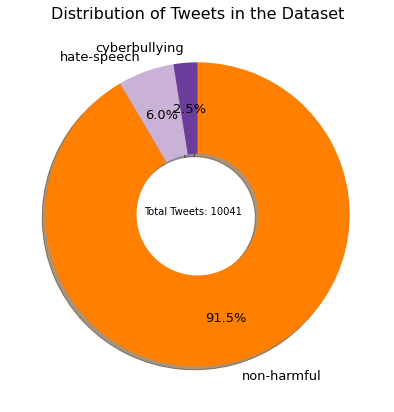

In [4]:
plt.figure(figsize = (7,7))
sorted_counts = df_train['label_text'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 13}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df_train.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16);

### create validation set for model validaiton during training

In [5]:
X_train, y_train = df_train[['text']], df_train[['label']]
X_test, y_test = df_test[['text']], df_test[['label']]

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                 y_train, 
                                                 random_state=42)

print('Number of rows in the total set: {}'.format(df_train.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 10041
Number of rows in the training set: 7530
Number of rows in the test set: 1000


# data cleaning

In [6]:
def clean_tweet(tweet):
    """
    Function that cleans a single tweet
    """
    entry = SentenceCleaner(tweet)
    entry.html_tag()
    entry.urls()
    entry.handle()
    entry.hashtag()
    entry.tolowercase()
    return entry.sentence


In [7]:
X_train = X_train['text'].apply(clean_tweet)
X_val = X_val['text'].apply(clean_tweet)
X_test = X_test['text'].apply(clean_tweet)

/home/michalnarbutt/misc/cyberbullying-detector/utils.py:59: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 59 of the file /home/michalnarbutt/misc/cyberbullying-detector/utils.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  self.sentence = BeautifulSoup(self.sentence).get_text()


In [8]:
X_train

4156    użytkownik użytkownik a ci co nie głosowali? w...
3065    matka każe mi iść ze sobą do kościoła xddddddd...
472     użytkownik użytkownik użytkownik w końcu jakiś...
2554     po maturze, chodziliśmy na carpaccio z tuńczyka.
6001    użytkownik jakby się okazało że nie mają dużo ...
                              ...                        
5734    rt użytkownik dobrze, że są ujawniane te afery...
5191    użytkownik a mówiłaś mu, ze ktoś tam cię przep...
5390    wczoraj oddaliśmy tu 2200 głosów na gortata. d...
860     a jarkacz siedzi z kotem i patrzy jak maszyna ...
7270    użytkownik no to super dziennikarz przeprowadz...
Name: text, Length: 7530, dtype: object

# pre-trained Polish Bert embeddings

In [9]:
from polishbert import *
embeddings, tokenizer = load_embeddings(model_dir = "roberta_base_transformers")

In [10]:
torch.__version__

'1.2.0'

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
max_seq = X_train.map(lambda x: len(x.split(" "))).max()
max_seq

30

In [15]:
%time
train_indices = tokenize_and_pad_text(X_train, max_seq, tokenizer).to(device)
val_indices = tokenize_and_pad_text(X_val, max_seq, tokenizer).to(device)
test_indices = tokenize_and_pad_text(X_test, max_seq, tokenizer).to(device)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs


In [16]:
embeddings = embeddings.to(device)

#### extract in batches due to the sheer size of the vector which cant fit in gpu memory and will take ages on the cpu



In [18]:
%%time

X_train = extract_in_batches(train_indices, embeddings, batch_size=30)
print("train")
X_val = extract_in_batches(val_indices, embeddings, batch_size=30)
print("val")
X_test = extract_in_batches(test_indices, embeddings, batch_size=30)
print("test")

train
val
test
CPU times: user 16.5 s, sys: 4.61 s, total: 21.1 s
Wall time: 20.8 s


In [ ]:
del embeddings

In [19]:
torch.cuda.empty_cache()

In [22]:
y_train = targets_to_tensor(y_train,'label')#.to(device, dtype=torch.float32)
y_val = targets_to_tensor(y_val,'label')#.to(device, dtype=torch.float32)
y_test = targets_to_tensor(y_test,'label')#.to(device, dtype=torch.float32)

In [23]:
torch.save(X_train, 'data/X_train.pt')
torch.save(y_train, 'data/y_train.pt')
torch.save(X_test, 'data/X_test.pt')
torch.save(X_val, 'data/X_val.pt')
torch.save(y_val, 'data/y_val.pt')
torch.save(y_test, 'data/y_test.pt')

# load

In [ ]:
import torch

In [ ]:
X_train = torch.load('X_train.pt')
y_train = torch.load('y_train.pt')
X_val = torch.load('X_val.pt')
y_val = torch.load('y_val.pt')

In [24]:
y_train.max()

tensor(2.)

# now for sentence classification we will use KimCNN

In [161]:
%reload_ext autoreload
%autoreload 2

from model import *

In [162]:
embed_num = X_train.shape[1]
embed_dim = X_train.shape[2]
class_num = len(y_train.unique())
class_num

3

In [163]:
embed_num, embed_dim, class_num

(30, 768, 3)

In [164]:
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

In [165]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [166]:
_, sums = y_train.unique(return_counts=True)
sums = np.array(sums)
weights=torch.Tensor(max(sums)/sums)

In [167]:
n_epochs = 50
batch_size = 10
lr = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(weights))

In [ ]:
from time import time

In [ ]:
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    start_time = time()
    train_loss = 0    
    model.train(True)
    
    for x_batch, y_batch, batch in generate_batch_data(X_train, y_train, batch_size):
        #x_batch = x_batch.to(device)
        #y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        optimizer.zero_grad()
        #print(y_pred)
        loss = loss_fn(y_pred, y_batch.to(dtype=torch.long))
        #loss = loss_fn(y_pred, dtype=torch.long))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= batch
    
    train_losses.append(train_loss)
    elapsed = time() - start_time
    model.eval() # disable dropout for deterministic output
    # deactivate autograd engine to reduce memory usage and speed up computations
    
    with torch.no_grad(): 
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(X_val, y_val, batch_size):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch.to(dtype=torch.long))
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)    
    print(
    "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
    % (epoch + 1, train_losses[-1], val_losses[-1], elapsed))

Epoch 1 Train loss: 0.98. Validation loss: 0.98. Elapsed time: 8.77s.
Epoch 2 Train loss: 0.97. Validation loss: 0.95. Elapsed time: 9.03s.
Epoch 3 Train loss: 0.94. Validation loss: 0.92. Elapsed time: 8.75s.
Epoch 4 Train loss: 0.92. Validation loss: 0.91. Elapsed time: 9.48s.
Epoch 5 Train loss: 0.91. Validation loss: 0.90. Elapsed time: 9.63s.
Epoch 6 Train loss: 0.90. Validation loss: 0.90. Elapsed time: 9.54s.
Epoch 7 Train loss: 0.89. Validation loss: 0.90. Elapsed time: 8.69s.
Epoch 8 Train loss: 0.88. Validation loss: 0.90. Elapsed time: 8.64s.
Epoch 9 Train loss: 0.88. Validation loss: 0.89. Elapsed time: 8.68s.
Epoch 10 Train loss: 0.87. Validation loss: 0.90. Elapsed time: 8.84s.
Epoch 11 Train loss: 0.86. Validation loss: 0.89. Elapsed time: 8.70s.
Epoch 12 Train loss: 0.86. Validation loss: 0.89. Elapsed time: 8.67s.
Epoch 13 Train loss: 0.85. Validation loss: 0.88. Elapsed time: 8.61s.
Epoch 14 Train loss: 0.85. Validation loss: 0.88. Elapsed time: 8.54s.
Epoch 15 Train 

Text(0.5, 1.0, 'Losses')

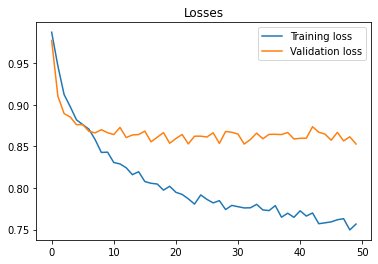

In [133]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

In [155]:
model.eval() 
y_preds = []
batch = 0
for x_batch, y_batch, batch in generate_batch_data(X_test, y_test, batch_size):
    y_pred = model(x_batch)
    y_pred = torch.argmax(y_pred, dim=1)
    y_preds.extend(y_pred.detach().numpy().tolist())
y_preds_np = np.array(y_preds)

In [156]:
torch.argmax(y_pred, dim=1)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [157]:
np.unique(y_preds_np, return_counts=True)

(array([0, 1, 2]), array([932,  15,  53]))

In [158]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

In [159]:
np.unique(y_preds_np)

array([0, 1, 2])

In [160]:
f1_score(np.array(y_test), y_preds_np, average='macro')

0.4925312532901212

In [ ]:
def load_trained_model(net, model_path, device):
    net.load_state_dict(
            torch.load(model_path, map_location=device))
    print("[*] Loaded weights from {}".format(model_path))
        
    net = net.to(device)
    net.eval()
    return net